In [1]:
from pathlib import Path
import pandas as pd

# Rutas robustas (funciona aunque el notebook esté en /notebooks)
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_RAW:", DATA_RAW, "| exists:", DATA_RAW.exists())
print("DATA_PROCESSED:", DATA_PROCESSED, "| exists:", DATA_PROCESSED.exists())

products = pd.read_csv(DATA_RAW / "products.csv")
tickets = pd.read_csv(DATA_RAW / "tickets.csv", parse_dates=["datetime"])
lines = pd.read_csv(DATA_RAW / "ticket_lines.csv", parse_dates=["datetime"])

print("shapes:", products.shape, tickets.shape, lines.shape)
products.head()

PROJECT_ROOT: c:\Users\danni\Documents\DataScient\proyecto_restaurant\restaurant-demand-optimization
DATA_RAW: c:\Users\danni\Documents\DataScient\proyecto_restaurant\restaurant-demand-optimization\data\raw | exists: True
DATA_PROCESSED: c:\Users\danni\Documents\DataScient\proyecto_restaurant\restaurant-demand-optimization\data\processed | exists: True
shapes: (60, 8) (12568, 12) (52081, 8)


,product_id,product_name,category,currency,unit_price_gross,unit_price_net,food_cost_unit,prep_minutes
0,1,Bebidas Item 1,Bebidas,CLP,4508,3788,676,15
1,2,Fondos Item 2,Fondos,CLP,12711,10682,3963,16
2,3,Bebidas Item 3,Bebidas,CLP,4044,3398,436,5
3,4,Postres Item 4,Postres,CLP,6942,5834,1599,16
4,5,Entradas Item 5,Entradas,CLP,7356,6182,1579,3


In [2]:
import numpy as np

# Unimos líneas + productos + tickets
df = (
    lines
    .merge(products, on="product_id", how="left", validate="many_to_one")
    .merge(
        tickets[["ticket_id", "party_size", "ticket_total_gross", "ticket_total_net", "food_cost_total", "tip_amount", "channel"]],
        on=["ticket_id", "channel"],
        how="left",
        validate="many_to_one"
    )
)

# Métricas por línea (neto)
df["margin_net"] = df["line_total_net"] - df["line_cost"]
df["margin_pct_net"] = np.where(df["line_total_net"] > 0, df["margin_net"] / df["line_total_net"], np.nan)

print("df shape:", df.shape)
print("missing product_name:", df["product_name"].isna().sum())
print("missing ticket_total_net:", df["ticket_total_net"].isna().sum())

df[["ticket_id","datetime","product_name","qty","line_total_net","line_cost","margin_net","channel"]].head()

df shape: (52081, 22)
missing product_name: 0
missing ticket_total_net: 0


,ticket_id,datetime,product_name,qty,line_total_net,line_cost,margin_net,channel
0,1,2025-11-01 20:41:00,Café Item 6,1,2656,397,2259,dine_in
1,1,2025-11-01 20:41:00,Bebidas Item 12,1,2805,596,2209,dine_in
2,1,2025-11-01 20:41:00,Postres Item 49,1,3306,864,2442,dine_in
3,1,2025-11-01 20:41:00,Fondos Item 2,1,10682,3963,6719,dine_in
4,1,2025-11-01 20:41:00,Postres Item 43,1,3946,986,2960,dine_in


In [3]:
def fmt_clp(x):
    # CLP: sin decimales, miles con punto
    return f"{x:,.0f}".replace(",", ".")

def fmt_pct(x, decimals=1):
    return (f"{x*100:.{decimals}f}%").replace(".", ",")

kpis_raw = {
    "tickets": int(tickets["ticket_id"].nunique()),
    "items_vendidos": int(lines["qty"].sum()),
    "ventas_brutas_CLP": float(tickets["ticket_total_gross"].sum()),
    "ventas_netas_CLP": float(tickets["ticket_total_net"].sum()),
    "food_cost_CLP": float(tickets["food_cost_total"].sum()),
}
kpis_raw["margen_neto_CLP"] = kpis_raw["ventas_netas_CLP"] - kpis_raw["food_cost_CLP"]
kpis_raw["food_cost_pct"] = kpis_raw["food_cost_CLP"] / kpis_raw["ventas_netas_CLP"]
kpis_raw["ticket_prom_neto_CLP"] = kpis_raw["ventas_netas_CLP"] / kpis_raw["tickets"]

kpis_fmt = {
    "tickets": kpis_raw["tickets"],
    "items_vendidos": kpis_raw["items_vendidos"],
    "ventas_brutas_CLP": fmt_clp(kpis_raw["ventas_brutas_CLP"]),
    "ventas_netas_CLP": fmt_clp(kpis_raw["ventas_netas_CLP"]),
    "food_cost_CLP": fmt_clp(kpis_raw["food_cost_CLP"]),
    "margen_neto_CLP": fmt_clp(kpis_raw["margen_neto_CLP"]),
    "food_cost_pct": fmt_pct(kpis_raw["food_cost_pct"]),
    "ticket_prom_neto_CLP": fmt_clp(kpis_raw["ticket_prom_neto_CLP"]),
}

kpis_fmt

{'tickets': 12568,
 'items_vendidos': 66746,
 'ventas_brutas_CLP': '456.537.528',
 'ventas_netas_CLP': '383.644.390',
 'food_cost_CLP': '109.043.168',
 'margen_neto_CLP': '274.601.222',
 'food_cost_pct': '28,4%',
 'ticket_prom_neto_CLP': '30.525'}

In [4]:
# Totales netos desde líneas vs totales netos en tickets
lines_net_by_ticket = (
    lines.groupby("ticket_id", as_index=False)["line_total_net"].sum()
    .rename(columns={"line_total_net": "net_from_lines"})
)

check = tickets[["ticket_id", "ticket_total_net"]].merge(lines_net_by_ticket, on="ticket_id", how="left")
check["diff"] = check["ticket_total_net"] - check["net_from_lines"]

print("tickets:", len(check))
print("max abs diff:", int(check["diff"].abs().max()))
print("mean abs diff:", float(check["diff"].abs().mean()))
check["diff"].describe()

tickets: 12568
max abs diff: 0
mean abs diff: 0.0


count    12568.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: diff, dtype: float64

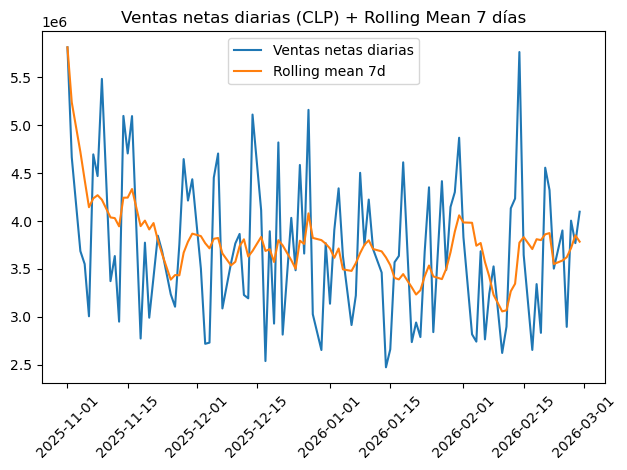

,date,ventas_netas,tickets,ventas_rolling_7d
0,2025-11-01,5812748,175,5812748.0
1,2025-11-02,4665339,159,5239043.5
2,2025-11-04,3686587,120,4721558.0
3,2025-11-05,3551458,115,4429033.0
4,2025-11-06,3006290,105,4144484.4


In [5]:
import matplotlib.pyplot as plt

daily = (
    tickets
    .assign(date=tickets["datetime"].dt.date)
    .groupby("date", as_index=False)
    .agg(
        ventas_netas=("ticket_total_net", "sum"),
        tickets=("ticket_id", "nunique")
    )
)

daily["ventas_rolling_7d"] = daily["ventas_netas"].rolling(7, min_periods=1).mean()

plt.figure()
plt.plot(daily["date"], daily["ventas_netas"], label="Ventas netas diarias")
plt.plot(daily["date"], daily["ventas_rolling_7d"], label="Rolling mean 7d")
plt.title("Ventas netas diarias (CLP) + Rolling Mean 7 días")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

daily.head()

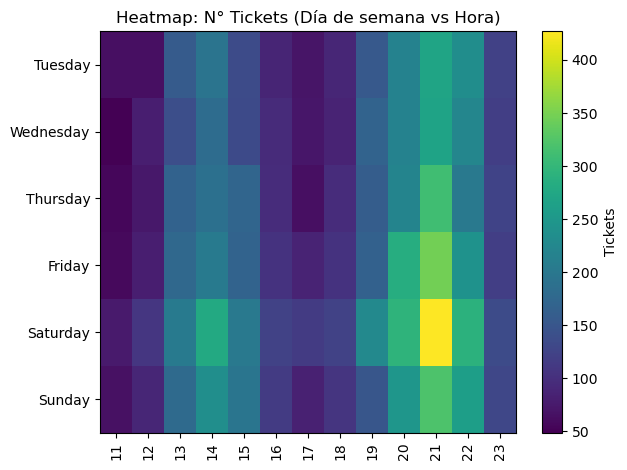

hour,11,12,13,14,15,16,17,18,19,20,21,22,23
dow,,,,,,,,,,,,,
Tuesday,64,64,158,195,136,88,71,90,155,216,270,234,122
Wednesday,49,81,140,183,134,95,72,87,170,217,269,223,119
Thursday,56,73,168,189,172,97,65,97,160,220,311,202,125
Friday,59,81,176,203,170,104,86,105,167,284,347,242,119
Saturday,77,109,203,278,202,123,114,124,227,295,427,292,135


In [6]:
# Creamos variables temporales
tmp = tickets.copy()
tmp["dow"] = tmp["datetime"].dt.day_name()
tmp["hour"] = tmp["datetime"].dt.hour

# Orden típico (lunes a domingo). Si lunes está cerrado, aparecerá igual con 0.
dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
tmp["dow"] = pd.Categorical(tmp["dow"], categories=dow_order, ordered=True)

pivot = (
    tmp.pivot_table(index="dow", columns="hour", values="ticket_id", aggfunc="count", fill_value=0)
    .sort_index()
)

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.title("Heatmap: N° Tickets (Día de semana vs Hora)")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=90)
plt.colorbar(label="Tickets")
plt.tight_layout()
plt.show()

pivot.head()

Productos para ~80% de ventas: 23 de 60


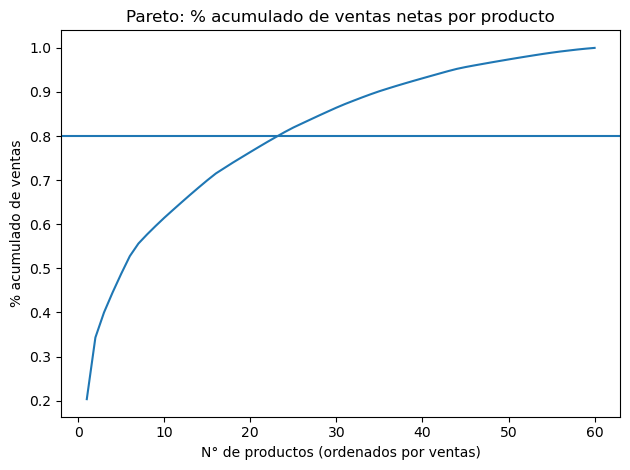

,product_id,product_name,ventas_netas,unidades,margen_neto,pct_ventas,pct_acum
1,2,Fondos Item 2,78053374,7307,49095733,0.203452,0.203452
0,1,Bebidas Item 1,53657020,14165,44081480,0.139861,0.343314
3,4,Postres Item 4,21766654,3731,15800785,0.056737,0.400050
4,5,Entradas Item 5,17439422,2821,12985063,0.045457,0.445508
2,3,Bebidas Item 3,16242440,4780,14158360,0.042337,0.487845
9,10,Fondos Item 10,15338592,1476,9781452,0.039981,0.527826
10,11,Fondos Item 11,10947384,1284,7620540,0.028535,0.556361
15,16,Fondos Item 16,7896603,869,5660666,0.020583,0.576944
16,17,Fondos Item 17,7397950,805,4334120,0.019283,0.596228
6,7,Bebidas Item 7,7097625,2103,6012477,0.018501,0.614728


In [7]:
import matplotlib.pyplot as plt

prod_sales = (
    df.groupby(["product_id", "product_name"], as_index=False)
      .agg(
          ventas_netas=("line_total_net", "sum"),
          unidades=("qty", "sum"),
          margen_neto=("margin_net", "sum")
      )
)

prod_sales = prod_sales.sort_values("ventas_netas", ascending=False)
prod_sales["pct_ventas"] = prod_sales["ventas_netas"] / prod_sales["ventas_netas"].sum()
prod_sales["pct_acum"] = prod_sales["pct_ventas"].cumsum()

# ¿Cuántos productos explican el 80%?
n_80 = int((prod_sales["pct_acum"] <= 0.80).sum())
print("Productos para ~80% de ventas:", n_80, "de", len(prod_sales))

# Curva de Pareto
plt.figure()
plt.plot(range(1, len(prod_sales) + 1), prod_sales["pct_acum"])
plt.axhline(0.80)
plt.title("Pareto: % acumulado de ventas netas por producto")
plt.xlabel("N° de productos (ordenados por ventas)")
plt.ylabel("% acumulado de ventas")
plt.tight_layout()
plt.show()

prod_sales.head(10)

In [8]:
# Popularidad (unidades) y margen por unidad
menu = prod_sales.copy()
menu["margen_por_unidad"] = menu["margen_neto"] / menu["unidades"]

# Umbrales (mediana) para clasificar
pop_thr = menu["unidades"].median()
mar_thr = menu["margen_por_unidad"].median()

def classify(row):
    popular = row["unidades"] >= pop_thr
    rentable = row["margen_por_unidad"] >= mar_thr
    if popular and rentable:
        return "Estrella"
    if popular and (not rentable):
        return "Caballo de batalla"
    if (not popular) and rentable:
        return "Puzzle"
    return "Perro"

menu["categoria_menu"] = menu.apply(classify, axis=1)

menu["categoria_menu"].value_counts()

categoria_menu
Caballo de batalla    16
Puzzle                16
Estrella              14
Perro                 14
Name: count, dtype: int64

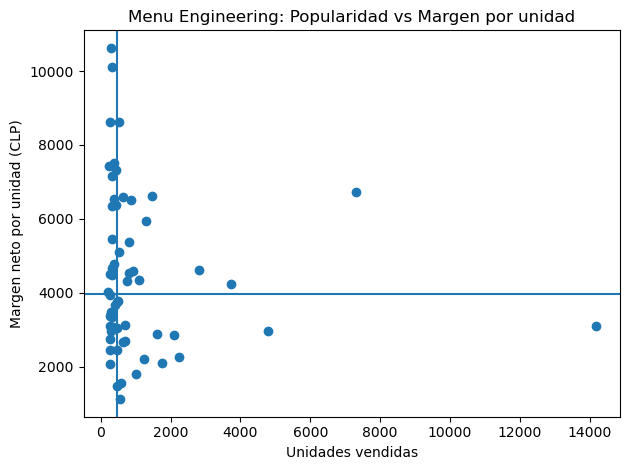

,product_id,product_name,ventas_netas,unidades,margen_neto,pct_ventas,pct_acum,margen_por_unidad,categoria_menu
0,1,Bebidas Item 1,53657020,14165,44081480,0.139861,0.343314,3112.0,Caballo de batalla
2,3,Bebidas Item 3,16242440,4780,14158360,0.042337,0.487845,2962.0,Caballo de batalla
6,7,Bebidas Item 7,7097625,2103,6012477,0.018501,0.614728,2859.0,Caballo de batalla
8,9,Entradas Item 9,6267984,1608,4616568,0.016338,0.699808,2871.0,Caballo de batalla
5,6,Café Item 6,5949440,2240,5060160,0.015508,0.715315,2259.0,Caballo de batalla
7,8,Bebidas Item 8,4231960,1756,3663016,0.011031,0.809205,2086.0,Caballo de batalla
11,12,Bebidas Item 12,3486615,1243,2745787,0.009088,0.846831,2209.0,Caballo de batalla
27,28,Entradas Item 28,2752944,498,1878456,0.007176,0.895009,3772.0,Caballo de batalla
20,21,Bebidas Item 21,2606452,691,2166976,0.006794,0.901803,3136.0,Caballo de batalla
18,19,Bebidas Item 19,2370368,704,1900096,0.006179,0.907981,2699.0,Caballo de batalla


In [9]:
plt.figure()
plt.scatter(menu["unidades"], menu["margen_por_unidad"])
plt.axvline(pop_thr)
plt.axhline(mar_thr)
plt.title("Menu Engineering: Popularidad vs Margen por unidad")
plt.xlabel("Unidades vendidas")
plt.ylabel("Margen neto por unidad (CLP)")
plt.tight_layout()
plt.show()

menu.sort_values(["categoria_menu","ventas_netas"], ascending=[True, False]).head(15)

In [10]:
menu["categoria_menu"].value_counts()

categoria_menu
Caballo de batalla    16
Puzzle                16
Estrella              14
Perro                 14
Name: count, dtype: int64

In [11]:
top_by_cat = (
    menu.sort_values("ventas_netas", ascending=False)
        .groupby("categoria_menu")
        .head(5)[["categoria_menu","product_name","ventas_netas","unidades","margen_por_unidad"]]
)
top_by_cat

,categoria_menu,product_name,ventas_netas,unidades,margen_por_unidad
1,Estrella,Fondos Item 2,78053374,7307,6719.0
0,Caballo de batalla,Bebidas Item 1,53657020,14165,3112.0
3,Estrella,Postres Item 4,21766654,3731,4235.0
4,Estrella,Entradas Item 5,17439422,2821,4603.0
2,Caballo de batalla,Bebidas Item 3,16242440,4780,2962.0
9,Estrella,Fondos Item 10,15338592,1476,6627.0
10,Estrella,Fondos Item 11,10947384,1284,5935.0
6,Caballo de batalla,Bebidas Item 7,7097625,2103,2859.0
8,Caballo de batalla,Entradas Item 9,6267984,1608,2871.0
5,Caballo de batalla,Café Item 6,5949440,2240,2259.0


In [12]:
# Tabla resumen con recomendación base
menu_actions = menu.copy()

menu_actions["accion"] = menu_actions["categoria_menu"].map({
    "Estrella": "Proteger + destacar (no descontar). Asegurar stock/producción.",
    "Caballo de batalla": "Optimizar margen: +precio leve / -costo / bundles de alto margen.",
    "Puzzle": "Aumentar visibilidad: recomendación, ubicación en menú, bundles sin descuento fuerte.",
    "Perro": "Eliminar o rediseñar: simplificar inventario y operación."
})

# Impacto potencial: si aumentas margen/u en +200 CLP (solo ilustrativo)
DELTA_MARGIN = 200
menu_actions["impacto_CLP_si_+200_margen_u"] = menu_actions["unidades"] * DELTA_MARGIN

menu_actions.sort_values("ventas_netas", ascending=False).head(12)[
    ["categoria_menu","product_name","ventas_netas","unidades","margen_por_unidad","accion","impacto_CLP_si_+200_margen_u"]
]

,categoria_menu,product_name,ventas_netas,unidades,margen_por_unidad,accion,impacto_CLP_si_+200_margen_u
1,Estrella,Fondos Item 2,78053374,7307,6719.0,Proteger + destacar (no descontar). Asegurar s...,1461400
0,Caballo de batalla,Bebidas Item 1,53657020,14165,3112.0,Optimizar margen: +precio leve / -costo / bund...,2833000
3,Estrella,Postres Item 4,21766654,3731,4235.0,Proteger + destacar (no descontar). Asegurar s...,746200
4,Estrella,Entradas Item 5,17439422,2821,4603.0,Proteger + destacar (no descontar). Asegurar s...,564200
2,Caballo de batalla,Bebidas Item 3,16242440,4780,2962.0,Optimizar margen: +precio leve / -costo / bund...,956000
9,Estrella,Fondos Item 10,15338592,1476,6627.0,Proteger + destacar (no descontar). Asegurar s...,295200
10,Estrella,Fondos Item 11,10947384,1284,5935.0,Proteger + destacar (no descontar). Asegurar s...,256800
15,Estrella,Fondos Item 16,7896603,869,6514.0,Proteger + destacar (no descontar). Asegurar s...,173800
16,Estrella,Fondos Item 17,7397950,805,5384.0,Proteger + destacar (no descontar). Asegurar s...,161000
6,Caballo de batalla,Bebidas Item 7,7097625,2103,2859.0,Optimizar margen: +precio leve / -costo / bund...,420600


In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW = PROJECT_ROOT / "data" / "raw"

products = pd.read_csv(DATA_RAW / "products.csv")
tickets = pd.read_csv(DATA_RAW / "tickets.csv", parse_dates=["datetime"])
lines = pd.read_csv(DATA_RAW / "ticket_lines.csv", parse_dates=["datetime"])

print(products.shape, tickets.shape, lines.shape)

In [ ]:
df = (
    lines
    .merge(products, on="product_id", how="left")
    .merge(tickets[["ticket_id","party_size","ticket_total_gross","ticket_total_net","food_cost_total","tip_amount","channel"]],
           on=["ticket_id","channel"], how="left")
)

df["margin_net"] = df["line_total_net"] - df["line_cost"]
df["margin_pct_net"] = np.where(df["line_total_net"] > 0, df["margin_net"] / df["line_total_net"], np.nan)

def fmt_clp(x): return f"{x:,.0f}".replace(",", ".")
def fmt_pct(x, d=1): return (f"{x*100:.{d}f}%").replace(".", ",")

kpis_raw = {
    "tickets": int(tickets["ticket_id"].nunique()),
    "items_vendidos": int(lines["qty"].sum()),
    "ventas_brutas_CLP": float(tickets["ticket_total_gross"].sum()),
    "ventas_netas_CLP": float(tickets["ticket_total_net"].sum()),
    "food_cost_CLP": float(tickets["food_cost_total"].sum()),
}
kpis_raw["margen_neto_CLP"] = kpis_raw["ventas_netas_CLP"] - kpis_raw["food_cost_CLP"]
kpis_raw["food_cost_pct"] = kpis_raw["food_cost_CLP"] / kpis_raw["ventas_netas_CLP"]
kpis_raw["ticket_prom_neto_CLP"] = kpis_raw["ventas_netas_CLP"] / kpis_raw["tickets"]

kpis_fmt = {
    "tickets": kpis_raw["tickets"],
    "items_vendidos": kpis_raw["items_vendidos"],
    "ventas_brutas_CLP": fmt_clp(kpis_raw["ventas_brutas_CLP"]),
    "ventas_netas_CLP": fmt_clp(kpis_raw["ventas_netas_CLP"]),
    "food_cost_CLP": fmt_clp(kpis_raw["food_cost_CLP"]),
    "margen_neto_CLP": fmt_clp(kpis_raw["margen_neto_CLP"]),
    "food_cost_pct": fmt_pct(kpis_raw["food_cost_pct"]),
    "ticket_prom_neto_CLP": fmt_clp(kpis_raw["ticket_prom_neto_CLP"]),
}
kpis_fmt

In [ ]:
# Pareto
prod_sales = (
    df.groupby(["product_id","product_name"], as_index=False)
      .agg(ventas_netas=("line_total_net","sum"),
           unidades=("qty","sum"),
           margen_neto=("margin_net","sum"))
).sort_values("ventas_netas", ascending=False)

prod_sales["pct_ventas"] = prod_sales["ventas_netas"] / prod_sales["ventas_netas"].sum()
prod_sales["pct_acum"] = prod_sales["pct_ventas"].cumsum()
n_80 = int((prod_sales["pct_acum"] <= 0.80).sum())
print("Productos para ~80% de ventas:", n_80, "de", len(prod_sales))

plt.figure()
plt.plot(range(1, len(prod_sales)+1), prod_sales["pct_acum"])
plt.axhline(0.80)
plt.title("Pareto: % acumulado de ventas netas por producto")
plt.xlabel("N° de productos (ordenados por ventas)")
plt.ylabel("% acumulado de ventas")
plt.tight_layout()
plt.show()

# Menu engineering
menu = prod_sales.copy()
menu["margen_por_unidad"] = menu["margen_neto"] / menu["unidades"]
pop_thr = menu["unidades"].median()
mar_thr = menu["margen_por_unidad"].median()

def classify(row):
    popular = row["unidades"] >= pop_thr
    rentable = row["margen_por_unidad"] >= mar_thr
    if popular and rentable: return "Estrella"
    if popular and (not rentable): return "Caballo de batalla"
    if (not popular) and rentable: return "Puzzle"
    return "Perro"

menu["categoria_menu"] = menu.apply(classify, axis=1)
menu["categoria_menu"].value_counts()